In [39]:
import tensorflow as tf

In [40]:
tf.__version__

'2.16.1'

In [41]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("CUDA available:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.16.1
CUDA available: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras


from IPython import display

In [43]:
#Wczytanie zdjęć treningowych (
images_train = []
labels_train = []

num_labels = 24

size = 70

noise_dim = 100



for i in range(1, 11):
    
    for j in range(1, size+1):

        im = Image.open(r'./Baza_zdjec_konwersja_64x64/s'+str(i)+'/'+str(j)+'.png')
        arr_im = np.array(im)
        arr_im = (arr_im - 127.5) / 127.5  # Normalize the images to [-1, 1]
        #arr_im = arr_im /255  # Normalize the images to [0, 1]
        arr_im = arr_im.astype(np.float32)
        images_train.append(arr_im)
        labels_train.append(i-1) 


for i in range(27, 41):
    
    for j in range(1, size+1):

        im = Image.open(r'./Baza_zdjec_konwersja_64x64/s'+str(i)+'/'+str(j)+'.png')
        arr_im = np.array(im)
        arr_im = (arr_im - 127.5) / 127.5  # Normalize the images to [-1, 1]
        #arr_im = arr_im /255  # Normalize the images to [0, 1]
        arr_im = arr_im.astype(np.float32)
        images_train.append(arr_im)
        labels_train.append(i-17) 


print(len(images_train))


#half = (num_labels-1)/2

labels_train = np.array(labels_train)


#labels_train = ((labels_train - half)/half).astype(np.float32)
#labels_train = (labels_train/(num_labels-1)).astype(np.float32)

labels_train = keras.utils.to_categorical(labels_train, num_classes=num_labels)


print(labels_train)

#train_labels = tf.one_hot(labels_train, num_labels)
#train_labels = tf.reshape(train_labels, (train_labels.shape[0], train_labels.shape[1]))



1680
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [44]:
labels_train.shape

(1680, 24)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


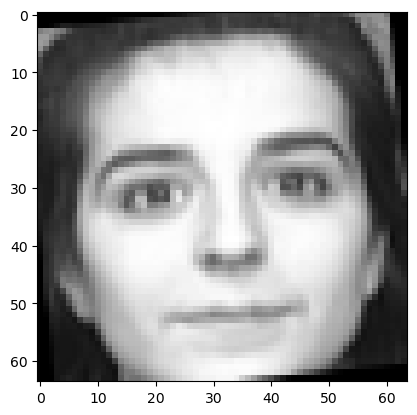

In [45]:
a = 669
plt.imshow(images_train[a],cmap = 'gray')
print(labels_train[a])

In [8]:
BUFFER_SIZE = 1680
BATCH_SIZE = 64

# Tworzenie zestawu danych z obrazów i etykiet
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))

# Tasowanie i dzielenie danych na partie
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

2024-06-09 21:51:52.754381: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-09 21:51:52.754517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-09 21:51:52.754587: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [46]:
def make_generator_model():

    noise_dim = 100
    label_dim = 24


    # Define noise and label inputs
    noise = keras.layers.Input(shape=(noise_dim,))
    label = keras.layers.Input(shape=(label_dim,))

     # Embedding label into a dense layer
    label_embedding = keras.layers.Dense(noise_dim)(label)
    
    # Concatenate noise and embedded label
    input_concat = keras.layers.Concatenate()([noise, label_embedding])

    
    
    model = keras.Sequential()
    
    model.add(keras.layers.Dense(16*16*256, use_bias=False, input_dim=noise_dim))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Reshape((16, 16, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
                           
    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    fake_image = model(input_concat)
    
    return keras.Model([noise, label], fake_image)
    
generator = make_generator_model()



ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_104" is incompatible with the layer: expected shape=(None, 100), found shape=(None, 200)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 200), dtype=float32, sparse=False, name=keras_tensor_710>',)
  • kwargs={'mask': 'None'}

In [37]:
def build_generator():
    noise_dim = 100
    label_dim = 10
    
    # Define noise and label inputs
    noise = keras.layers.Input(shape=(noise_dim,))
    label = keras.layers.Input(shape=(label_dim,))
    
    # Embedding label into a dense layer
    label_embedding = keras.layers.Dense(noise_dim)(label)
    
    # Concatenate noise and embedded label
    input_concat = keras.layers.Concatenate()([noise, label_embedding])
    
    # Define the generator model
    model = keras.Sequential()
    model.add(keras.layers.Dense(7*7*256, input_dim=noise_dim + noise_dim))  # noise_dim + noise_dim because label is embedded to noise_dim size
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Reshape((7, 7, 256)))
    
    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    
    # Get the fake image output
    fake_image = model(input_concat)
    
    return keras.Model([noise, label], fake_image)
    
generator = build_generator()

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_75" is incompatible with the layer: expected shape=(None, 110), found shape=(None, 200)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 200), dtype=float32, sparse=False, name=keras_tensor_589>',)
  • kwargs={'mask': 'None'}

In [33]:
def make_discriminator_model(input_layer, condition_layer):
    img_input = input_layer  # Image input
    disc_cond_in = condition_layer  # Condition input

    hid = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(img_input)
    hid = layers.LeakyReLU()(hid)
    hid = layers.Dropout(0.3)(hid)
    
    hid = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(hid)
    hid = layers.LeakyReLU()(hid)
    hid = layers.Dropout(0.3)(hid)
    
    hid = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(hid) # Additional layer
    hid = layers.LeakyReLU()(hid)
    hid = layers.Dropout(0.3)(hid)
    
    hid = layers.Flatten()(hid)
    merged = layers.Concatenate()([hid, disc_cond_in])
    
    hid = layers.Dense(128)(merged)
    hid = layers.LeakyReLU()(hid)
    
    out = layers.Dense(1)(hid)  # No sigmoid activation because we use Cross Entropy with from_logits=True

    model = tf.keras.Model(inputs=[img_input, disc_cond_in], outputs=out)
    return model


In [34]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

noise_input = layers.Input(shape=(noise_dim,)) # Noise input
gen_cond_in = layers.Input(shape=(1,)) # Condition input
generator = make_generator_model()



img_input = layers.Input(shape=(64, 64, 1)) # Image input
disc_cond_in = layers.Input(shape=(1,)) # Condition input
discriminator = make_discriminator_model(img_input, disc_cond_in)




generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images, labels):
    noise_dim = 100
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
        generated_images = generator([noise, labels], training=True)

        
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

ValueError: Inputs have incompatible shapes. Received shapes (16, 16, 256) and (124,)

In [28]:
'''
def generate_and_save_images(model_path, num_images=10, label=-1, save_path=None):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model = tf.keras.models.load_model(model_path)
    noise_dim = 100
    noise = tf.random.normal([num_images, noise_dim])
    labels = np.array([label] * num_images).reshape(-1, 1)
    labels = tf.cast(labels, tf.float32)  # Konwersja etykiet do typu tf.float32

    generator_input = tf.concat([noise, labels], axis=1)
    generated_images = model(generator_input, training=False)
    generated_images = (generated_images + 1) / 2.0

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
        if save_path:
            img = Image.fromarray((generated_images[i, :, :, 0] * 255).numpy().astype(np.uint8))
            img.save(f"{save_path}/generated_image_{i}.png")
    plt.show()
'''

'\ndef generate_and_save_images(model_path, num_images=10, label=-1, save_path=None):\n    if not os.path.exists(save_path):\n        os.makedirs(save_path)\n    model = tf.keras.models.load_model(model_path)\n    noise_dim = 100\n    noise = tf.random.normal([num_images, noise_dim])\n    labels = np.array([label] * num_images).reshape(-1, 1)\n    labels = tf.cast(labels, tf.float32)  # Konwersja etykiet do typu tf.float32\n\n    generator_input = tf.concat([noise, labels], axis=1)\n    generated_images = model(generator_input, training=False)\n    generated_images = (generated_images + 1) / 2.0\n\n    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2, 2))\n    for i in range(num_images):\n        axs[i].imshow(generated_images[i, :, :, 0], cmap=\'gray\')\n        axs[i].axis(\'off\')\n        if save_path:\n            img = Image.fromarray((generated_images[i, :, :, 0] * 255).numpy().astype(np.uint8))\n            img.save(f"{save_path}/generated_image_{i}.png")\n    plt

In [15]:
def generate_and_save(model, label):

    noise_dim = 100
    
    num_samples = 16

    label_print = label

    half = (num_labels-1)/2
    label = np.array(label)
    #label = ((label - half)/half).astype(np.float32)
    label = (label/(num_labels-1)).astype(np.float32)
    
    print(label)
    
    labels = [[label] for _ in range(num_samples)]
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    
    noise = tf.random.normal([num_samples, noise_dim])




    predictions = model([noise, labels], training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'images/image_at_epoch_{epoch+1:04d}_label_{label_print}.png')
    plt.show()

Rozpoczynam działanie


2024-06-09 21:55:08.196164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:55:09.580563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:55:10.956672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:55:12.336853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:55:13.716577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:55:15.099825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:55:16.480987: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 100
################
0.39130434


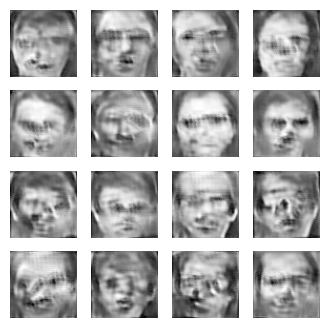

Modele zapisane po 100 epokach.


2024-06-09 21:57:29.934729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:57:31.351219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:57:32.770957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:57:34.188817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:57:35.607435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:57:37.027521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:57:38.445222: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 200
################
0.39130434


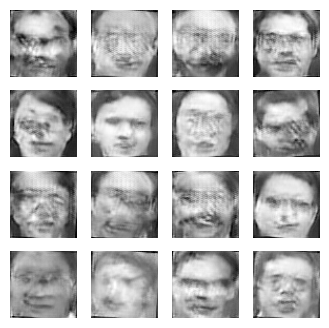

Modele zapisane po 200 epokach.


2024-06-09 21:59:52.938388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:59:54.353653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:59:55.770922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:59:57.196714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 21:59:58.614523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:00:00.035565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:00:01.461183: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 300
################
0.39130434


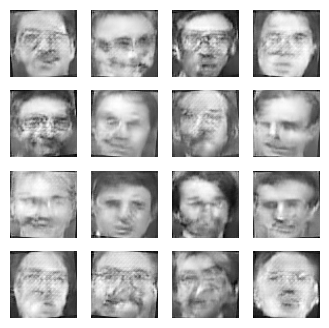

Modele zapisane po 300 epokach.


2024-06-09 22:02:16.077279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:02:17.494270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:02:18.915385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:02:20.337970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:02:21.754722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:02:23.174928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:02:24.598889: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 400
################
0.39130434


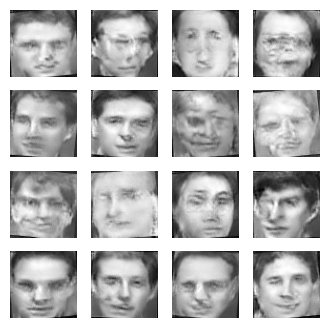

Modele zapisane po 400 epokach.


2024-06-09 22:04:39.164950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:04:40.580739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:04:42.002279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:04:43.428439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:04:44.848589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:04:46.270818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:04:47.693153: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 500
################
0.39130434


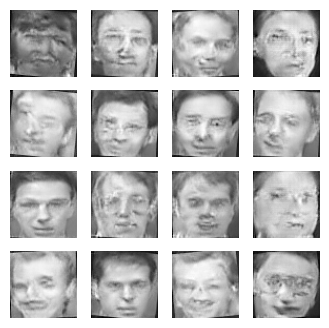

Modele zapisane po 500 epokach.


2024-06-09 22:07:02.297006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:07:03.711133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:07:05.138064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:07:06.560976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:07:07.983157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:07:09.399612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:07:10.826318: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 600
################
0.39130434


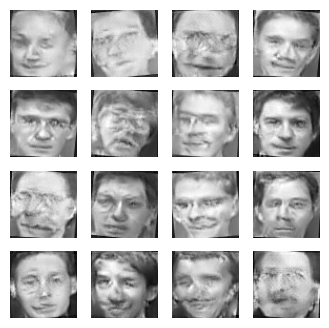

Modele zapisane po 600 epokach.


2024-06-09 22:09:25.404203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:09:26.832479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:09:28.252599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:09:29.670534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:09:31.094006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:09:32.515733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:09:33.937204: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 700
################
0.39130434


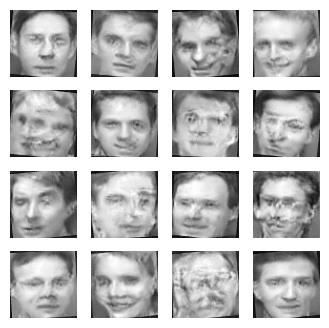

Modele zapisane po 700 epokach.


2024-06-09 22:11:48.552955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:11:49.971410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:11:51.392362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:11:52.813500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:11:54.231056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:11:55.656592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:11:57.080190: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 800
################
0.39130434


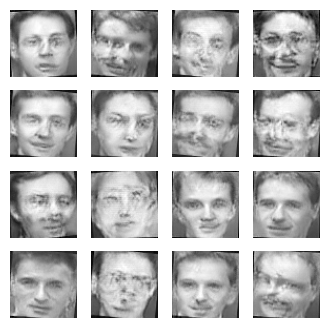

Modele zapisane po 800 epokach.


2024-06-09 22:14:11.817233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:14:13.238616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:14:14.662500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:14:16.081948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:14:17.499163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:14:18.925571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:14:20.345639: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 900
################
0.39130434


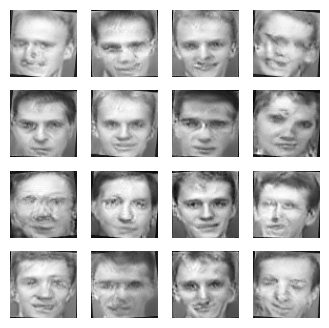

Modele zapisane po 900 epokach.


2024-06-09 22:16:34.995532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:16:36.419487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:16:37.838755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:16:39.259564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:16:40.682780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:16:42.105141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:16:43.528867: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 1000
################
0.39130434


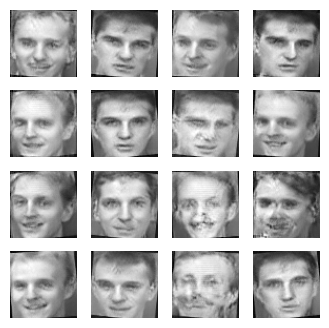

Modele zapisane po 1000 epokach.


2024-06-09 22:18:58.190266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:18:59.612738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:19:01.033321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:19:02.458993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:19:03.879574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:19:05.306799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:19:06.730661: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 1100
################
0.39130434


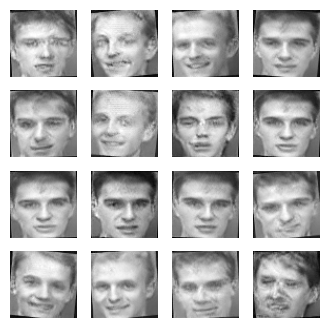

Modele zapisane po 1100 epokach.


2024-06-09 22:21:21.447808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:21:22.868848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:21:24.291118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:21:25.708004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:21:27.134183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:21:28.557752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:21:29.977275: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 1200
################
0.39130434


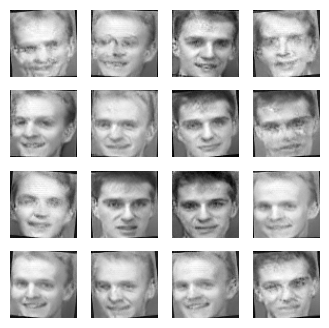

Modele zapisane po 1200 epokach.


2024-06-09 22:23:44.979456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:23:46.398958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:23:47.823880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:23:49.243654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:23:50.666990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:23:52.082180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:23:53.505244: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 1300
################
0.39130434


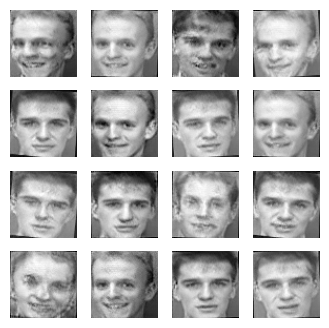

Modele zapisane po 1300 epokach.


2024-06-09 22:26:08.171718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:26:09.593193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:26:11.014284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:26:12.436242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:26:13.858098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:26:15.275804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:26:16.700872: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 1400
################
0.39130434


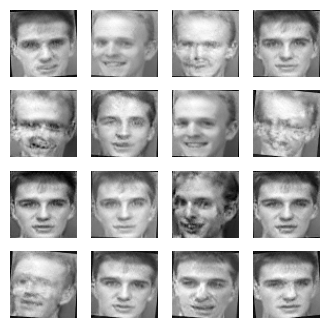

Modele zapisane po 1400 epokach.


2024-06-09 22:28:31.328028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:28:32.747130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:28:34.170678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:28:35.592034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:28:37.010752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:28:38.433338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:28:39.860399: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 1500
################
0.39130434


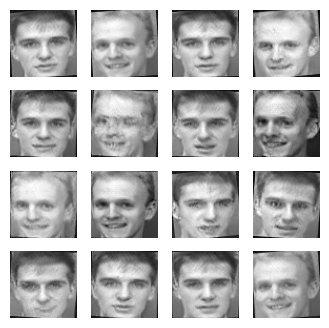

Modele zapisane po 1500 epokach.


2024-06-09 22:30:54.518531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:30:55.938700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:30:57.364465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:30:58.782398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:31:00.203599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:31:01.623569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:31:03.044700: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 1600
################
0.39130434


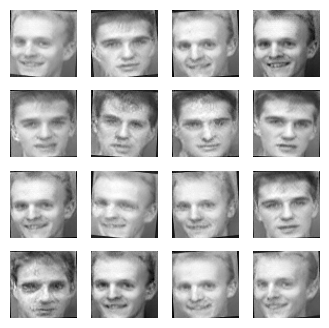

Modele zapisane po 1600 epokach.


2024-06-09 22:33:17.821290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:33:19.242402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:33:20.664131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:33:22.086984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:33:23.502592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:33:24.930546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:33:26.353062: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 1700
################
0.39130434


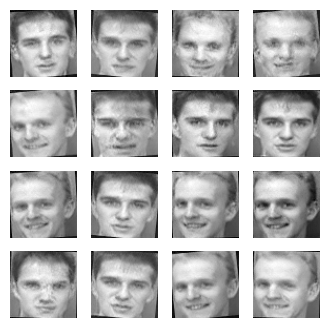

Modele zapisane po 1700 epokach.


2024-06-09 22:35:41.003596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:35:42.424415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:35:43.841297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:35:45.270010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:35:46.686851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:35:48.113677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:35:49.529170: W tensorflow/core/framework/local_rendezvous.cc:404] L

################
Epoka: 1800
################
0.39130434


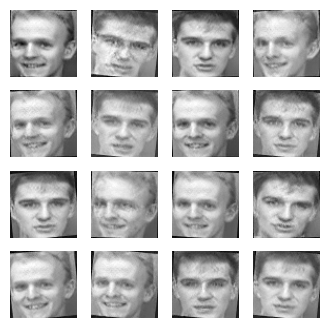

Modele zapisane po 1800 epokach.


2024-06-09 22:38:04.137921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:38:05.555706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:38:06.977242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:38:08.397677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:38:09.821127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:38:11.241970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-09 22:38:12.665447: W tensorflow/core/framework/local_rendezvous.cc:404] L

KeyboardInterrupt: 

In [16]:
EPOCHS = 40000

print('Rozpoczynam działanie')

for epoch in range(EPOCHS):
    for image_batch, label_batch in train_dataset:
        train_step(image_batch, label_batch)
    
    if (epoch + 1) % 100 == 0:
        print('################')
        print(f'Epoka: {epoch + 1}')
        print('################')
    
    # Zapisanie modelu co 2000 epok
    if (epoch + 1) % 100 == 0:
        generate_and_save(generator, 9)
        generator.save(f'./Generator/generator_model_epoch_{epoch + 1}.h5')
        discriminator.save(f'./Discriminator/discriminator_model_epoch_{epoch + 1}.h5')
        print(f'Modele zapisane po {epoch + 1} epokach.')

# Zapisanie modelu po zakończeniu treningu
generator.save('./Generator/generator_model_final.h5')
discriminator.save('./Discriminator/discriminator_model_final.h5')

In [25]:
def generate_new(model_path, label):
    model = tf.keras.models.load_model(model_path)
    noise_dim = 100
    
    num_samples = 16

    label_print = label

    half = (num_labels-1)/2
    label = np.array(label)
    label = ((label - half)/half).astype(np.float32)

    print(label)
    
    labels = [[label] for _ in range(num_samples)]
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    
    noise = tf.random.normal([num_samples, noise_dim])




    predictions = model([noise, labels], training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch+1:04d}_label_{label_print}.png')
    plt.show()

In [26]:
noise = tf.random.normal([16, noise_dim])

0.3043478


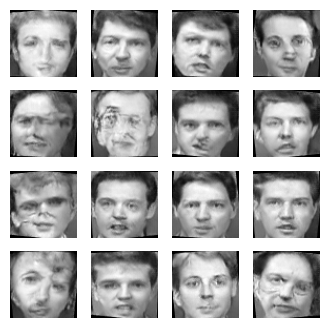

In [29]:
generate_new('./Generator/generator_model_final.h5', 9)